# Building General Dynamical Systems

@[Chaoming Wang](mailto:adaduo@outlook.com) @[Xiaoyu Chen](mailto:c-xy17@tsinghua.org.cn)

> What I cannot create, I do not understand.   --- Richard Feynman

The previous sections have shown how to build neuron models, synapse models, and network models. In fact, these brain objects all inherit the base class **`brainpy.DynamicalSystem`**, which is the universal language to define dynamical models in BrainPy.

To begin with, let's make a rief summary of previous dynamic models and give the definition of a dynamical system.

## What is a dynamical system?

Looking back to the neuron and synapse models defined in the previous sections, they share a common feature that **they all contain some variables that change over time**. Because of these variables, the models become 'dynamic' and behave differently at different times.

Actually, a *dynamical system* is defined as a system with time-dependent states. These time-dependent states are displayed as variables in the previous models.

Mathematically, the change of a state $X$ can be expressed as

$$
\dot{X} = f(X, t)
$$

where $X$ is the state of the system, $t$ is the time, and $f$ is a function describing the time dependence of the state. 

Alternatively, the evolution of the system over time can be given by

$$
X(t+dt) = F\left(X(t), t, dt\right)
$$

where $dt$ is the time step and $F$ is the evolution rule to update the system's state.

## ``brainpy.DynamicalSystem``

### General structure of `brainpy.DynamicalSystem`

For efficient dynamics simulation, [`brainpy.DynamicalSystem`](../apis/simulation/generated/brainpy.simulation.brainobjects.DynamicalSystem.rst) is provided in BrainPy to define brain objects with dynamic properties. Various subclasses are implemented to model these objects, such as [brainpy.Channel](../apis/simulation/generated/brainpy.simulation.brainobjects.Channel.rst) for neuron channels, [brainpy.NeuGroup](../apis/simulation/generated/brainpy.simulation.brainobjects.NeuGroup.rst) for neuron groups, [brainpy.TwoEndConn](../apis/simulation/generated/brainpy.simulation.brainobjects.TwoEndConn.rst) for synaptic connections, [brainpy.Network](../apis/simulation/generated/brainpy.simulation.brainobjects.Network.rst) for networks, etc. Arbitrary composition of these objects is also an instance of ``brainpy.DynamicalSystem``.

Below is the inheritance of different brain objects from `brainpy.DynamicalSystem`.

<img src="../_static/inheritance.png" width="750 px">

According to the mathematic expression of a dynamic state, any subclass of ``brainpy.DynamicalSystem`` must implement an updating rule in the ``update(self, _t, _dt)`` function. A dynamical system may have multiple updating rules, so users can define multiple *update* functions. All updating functions are wrapped into an inner data structure **self.steps** (a Python dictionary specifies the *name* and the *function* of updating rules). 

### Customizing your dynamical systems

Besides the objects that are pre-defined in BrainPy, users are allowed to customize their dynamical systems as well. To define a dynamical system, the following requirements should be satisfied:
- Inherit `brainpy.DynamicalSystem`.
- Implement the `update(self, _t, _dt)` function.
- When defining variables, they should be packed by `brainpy.math.Variable`.
- When updating the variables, it should be realized by in-place operations.

Below is a simple example of a dynamical system.

In [1]:
import brainpy as bp
import brainpy.math as bm

bm.set_platform('cpu')

In [2]:
class FitzHughNagumoModel(bp.DynamicalSystem):
    def __init__(self, a=0.8, b=0.7, tau=12.5, **kwargs):
        super(FitzHughNagumoModel, self).__init__(**kwargs)
        
        # parameters
        self.a = a
        self.b = b
        self.tau = tau
        
        # variables should be packed by brainpy.math.Variable
        self.v = bm.Variable([0.])
        self.w = bm.Variable([0.])
        self.I = bm.Variable([0.])
        
    def update(self, _t, _dt):
        # _t : the current time, the system keyword 
        # _dt : the time step, the system keyword 
        
        # in-place update, such as x[:] = ...
        self.w[:] += (self.v + self.a - self.b * self.w) / self.tau * _dt
        self.v[:] += (self.v - self.v ** 3 / 3 - self.w + self.I) * _dt
        self.I[:] = 0.

Here, we have defined a dynamical system called [FitzHugh–Nagumo neuron model](https://en.wikipedia.org/wiki/FitzHugh%E2%80%93Nagumo_model), whose dynamics is given by: 

$$
{\dot {v}}=v-{\frac {v^{3}}{3}}-w+I, \\
\tau {\dot {w}}=v+a-bw.
$$

By using the [Euler method](../apis/integrators/generated/brainpy.integrators.ode.explicit_rk.Euler.rst), this system can be updated by the following rule:

$$
\begin{aligned}
v(t+dt) &= v(t) + [v(t)-{v(t)^{3}/3}-w(t)+RI] * dt, \\
w(t + dt) &= w(t) + [v(t) + a - b w(t)] * dt.
\end{aligned}
$$

We can inspect all update functions in the model by ``xxx.steps``. 

In [3]:
fnh = FitzHughNagumoModel()

fnh.steps  # all update functions

{'update': <bound method FitzHughNagumoModel.update of <__main__.FitzHughNagumoModel object at 0x0000014635129190>>}

## Advantages of using `brainpy.DynamicalSystem`

There are several advantages of defining a dynamical system as `brainpy.DynamicalSystem`. 

### 1. A systematic naming system. 

First, every instance of ``DynamicalSystem`` has its unique name.

In [4]:
fnh.name  # name for "fnh" instance

'FitzHughNagumoModel0'

Every instance has its unique name:

In [5]:
for _ in range(3):
    print(FitzHughNagumoModel().name)

FitzHughNagumoModel1
FitzHughNagumoModel2
FitzHughNagumoModel3


Users can also specify the name of a dynamic system:

In [6]:
fnh2 = FitzHughNagumoModel(name='X')

fnh2.name

'X'

In [7]:
# same name will cause error

try:
    FitzHughNagumoModel(name='X')
except bp.errors.UniqueNameError as e:
    print(e)

In BrainPy, each object should have a unique name. However, we detect that <__main__.FitzHughNagumoModel object at 0x000001465228AA60> has a used name "X".


Second, variables, children nodes, etc. inside an instance can be easily accessed by their *absolute* or *relative* path. 

In [8]:
# All variables can be acessed by 
# 1). the absolute path

fnh2.vars()

{'X.I': Variable(DeviceArray([0.], dtype=float32)),
 'X.v': Variable(DeviceArray([0.], dtype=float32)),
 'X.w': Variable(DeviceArray([0.], dtype=float32))}

In [9]:
# 2). or, the relative path

fnh2.vars(method='relative')

{'I': Variable(DeviceArray([0.], dtype=float32)),
 'v': Variable(DeviceArray([0.], dtype=float32)),
 'w': Variable(DeviceArray([0.], dtype=float32))}

### 2. Convenient operations for simulation and analysis.
Brainpy provides different runners for dynamics simulation and analyzers for dynamics analysis, both of which require the dynamic model to be `Brainpy.DynamicalSystem`. For example, dynamic models can be packed by a runner for simulation:

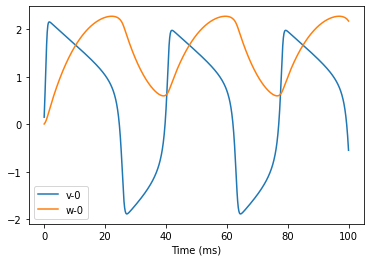

In [10]:
runner = bp.StructRunner(fnh2, monitors=['v', 'w'], inputs=('I', 1.5))
runner(duration=100)

bp.visualize.line_plot(runner.mon.ts, runner.mon.v, legend='v', show=False)
bp.visualize.line_plot(runner.mon.ts, runner.mon.w, legend='w', show=True)

Please see [Dynamics Simulation](../tutorial_simulation/index.rst) to know more about the operations in dynamics simulation.

### 3. Efficient computation.

``brainpy.DynamicalSystem`` is a subclass of [brainpy.Base](../apis/generated/brainpy.base.Base.rst), and therefore, any instance of ``brainpy.DynamicalSystem`` can be complied [just-in-time](./jit_compilation.ipynb) into efficient machine codes targeting on CPUs, GPUs, and TPUs. 

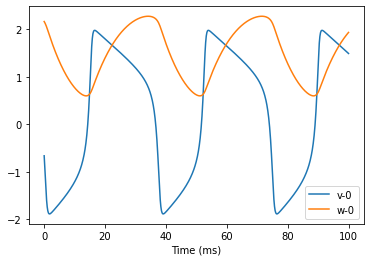

In [11]:
# jit compilation for class objects
fnh2_jit = bm.jit(fnh2)

runner = bp.StructRunner(fnh2_jit, monitors=['v', 'w'], inputs=('I', 1.5))
runner(duration=100)

bp.visualize.line_plot(runner.mon.ts, runner.mon.v, legend='v', show=False)
bp.visualize.line_plot(runner.mon.ts, runner.mon.w, legend='w', show=True)

### 4. Free combination.
Instances of ``brainpy.DynamicalSystem`` can be combined at will. The combined system is also a `brainpy.DynamicalSystem` and enjoys all the properties, methods, and interfaces provided by `brainpy.DynamicalSystem`.

For example, if the instances are wrapped into a container, i.e. `brainpy.Network`, variables and nodes can also be accessed by their absolute or relative path.

In [12]:
fnh_net = bp.Network(f1=fnh, f2=fnh2)

In [13]:
# absolute access of variables

fnh_net.vars()

{'FitzHughNagumoModel0.I': Variable(DeviceArray([0.], dtype=float32)),
 'FitzHughNagumoModel0.v': Variable(DeviceArray([0.], dtype=float32)),
 'FitzHughNagumoModel0.w': Variable(DeviceArray([0.], dtype=float32)),
 'X.I': Variable(DeviceArray([0.], dtype=float32)),
 'X.v': Variable(DeviceArray([1.4925911], dtype=float32)),
 'X.w': Variable(DeviceArray([1.9365356], dtype=float32))}

In [14]:
# relative access of variables

fnh_net.vars(method='relative')

{'f1.I': Variable(DeviceArray([0.], dtype=float32)),
 'f1.v': Variable(DeviceArray([0.], dtype=float32)),
 'f1.w': Variable(DeviceArray([0.], dtype=float32)),
 'f2.I': Variable(DeviceArray([0.], dtype=float32)),
 'f2.v': Variable(DeviceArray([1.4925911], dtype=float32)),
 'f2.w': Variable(DeviceArray([1.9365356], dtype=float32))}

In [15]:
# absolute access of nodes

fnh_net.nodes()

{'FitzHughNagumoModel0': <__main__.FitzHughNagumoModel at 0x14635129190>,
 'X': <__main__.FitzHughNagumoModel at 0x1465228a2e0>,
 'Network0': <brainpy.simulation.brainobjects.network.Network at 0x14653ce0700>}

In [16]:
# relative access of nodes

fnh_net.nodes(method='relative')

{'': <brainpy.simulation.brainobjects.network.Network at 0x14653ce0700>,
 'f1': <__main__.FitzHughNagumoModel at 0x14635129190>,
 'f2': <__main__.FitzHughNagumoModel at 0x1465228a2e0>}

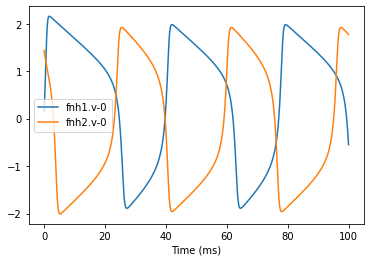

In [17]:
runner = bp.StructRunner(fnh_net, 
                         monitors=['f1.v', 'X.v'], 
                         inputs=[('f1.I', 1.5),   # relative access to variable "I" in 'fnh1'
                                 ('X.I', 1.0),])  # absolute access to variable "I" in 'fnh2'
runner(duration=100)

bp.visualize.line_plot(runner.mon.ts, runner.mon['f1.v'], legend='fnh1.v', show=False)
bp.visualize.line_plot(runner.mon.ts, runner.mon['X.v'], legend='fnh2.v', show=True)